In [2]:
import random
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
import numpy as np
import pickle
from joblib import Parallel, delayed
from math import log2, ceil
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
from proglearn.sims import generate_gaussian_parity

# Simulation Data Generation


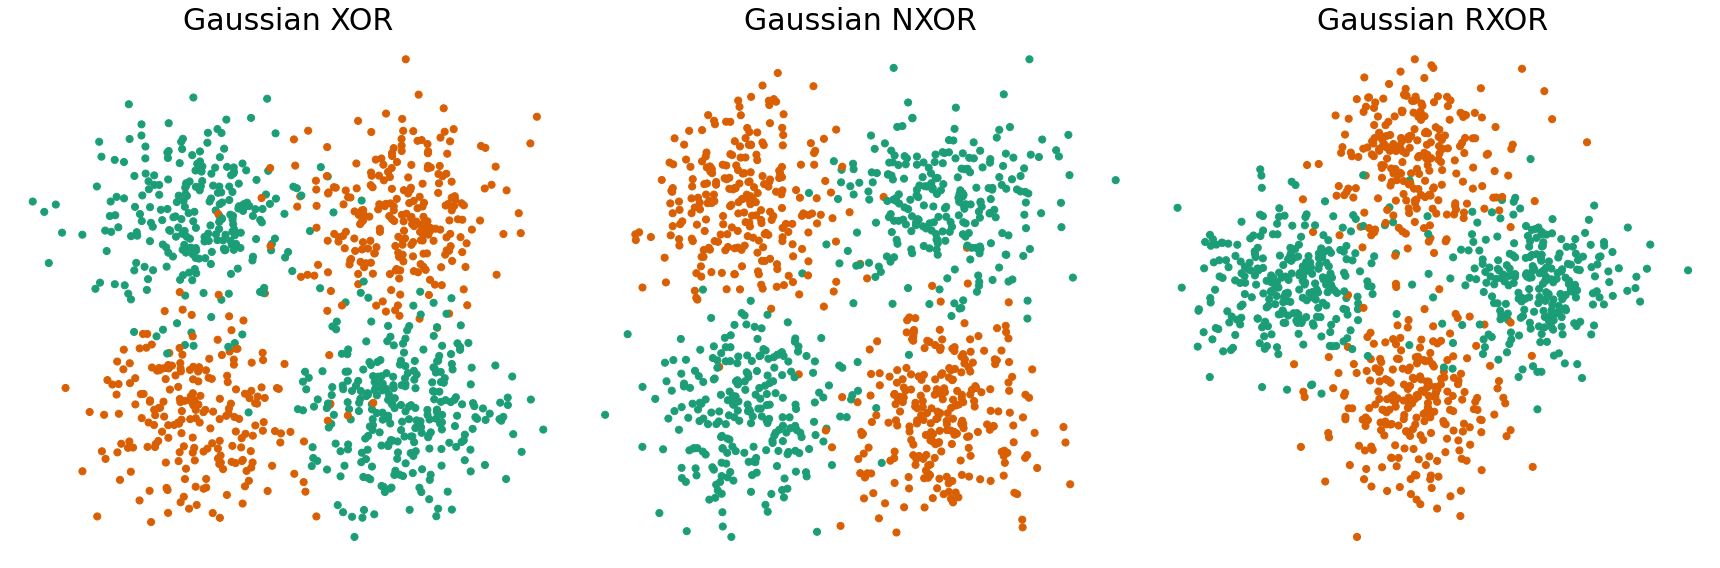

In [2]:
X_xor, y_xor = generate_gaussian_parity(1000)
X_nxor, y_nxor = generate_gaussian_parity(1000, angle_params=np.pi/2)
X_rxor, y_rxor = generate_gaussian_parity(1000, angle_params=np.pi/4)

colors = sns.color_palette('Dark2', n_colors=2)

fig, ax = plt.subplots(1,3, figsize=(24,8))

clr = [colors[i] for i in y_xor]
ax[0].scatter(X_xor[:, 0], X_xor[:, 1], c=clr, s=50)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Gaussian XOR', fontsize=30)
ax[0].axis('off')

clr = [colors[i] for i in y_nxor]
ax[1].scatter(X_nxor[:, 0], X_nxor[:, 1], c=clr, s=50)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Gaussian NXOR', fontsize=30)
ax[1].axis('off')

clr = [colors[i] for i in y_rxor]
ax[2].scatter(X_rxor[:, 0], X_rxor[:, 1], c=clr, s=50)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Gaussian RXOR', fontsize=30)
ax[2].axis('off')

plt.tight_layout()

# Experiment definition

In [5]:
def experiment(n_task1, n_task2, n_test=1000, 
               task1_angle=0, task2_angle=np.pi/2, 
               n_trees=10, max_depth=None, random_state=None):
    
    """
    A function to do progressive experiment between two tasks
    where the task data is generated using Gaussian parity.
    
    Parameters
    ----------
    n_task1 : int
        Total number of train sample for task 1.
    
    n_task2 : int
        Total number of train dsample for task 2

    n_test : int, optional (default=1000)
        Number of test sample for each task.
        
    task1_angle : float, optional (default=0)
        Angle in radian for task 1.
            
    task2_angle : float, optional (default=numpy.pi/2)
        Angle in radian for task 2.
            
    n_trees : int, optional (default=10)
        Number of total trees to train for each task.

    max_depth : int, optional (default=None)
        Maximum allowable depth for each tree.
        
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
        
    
    Returns
    -------
    errors : array of shape [6]
        Elements of the array is organized as single task error task1,
        multitask error task1, single task error task2,
        multitask error task2, naive UF error task1,
        naive UF task2.
    """

    if n_task1==0 and n_task2==0:
        raise ValueError('Wake up and provide samples to train!!!')

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6,dtype=float)

    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(2)}
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    naive_uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    
    #source data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)

    #target data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task2_angle)

    if n_task1 == 0:
        progressive_learner.add_task(X_task2, y_task2, num_transformers=n_trees)

        errors[0] = 0.5
        errors[1] = 0.5

        uf_task2=progressive_learner.predict(test_task2,
                                             transformer_ids=[0], task_id=0)
        l2f_task2=progressive_learner.predict(test_task2, task_id=0)

        errors[2] = 1 - np.mean(uf_task2 == test_label_task2)
        errors[3] = 1 - np.mean(l2f_task2 == test_label_task2)
        
        errors[4] = 0.5
        errors[5] = 1 - np.mean(uf_task2 == test_label_task2)
    elif n_task2 == 0:
        progressive_learner.add_task(X_task1, y_task1,
                                     num_transformers=n_trees)

        uf_task1=progressive_learner.predict(test_task1, 
                                             transformer_ids=[0], task_id=0)
        l2f_task1=progressive_learner.predict(test_task1, task_id=0)

        errors[0] = 1 - np.mean(uf_task1 == test_label_task1)
        errors[1] = 1 - np.mean(l2f_task1 == test_label_task1)
        
        errors[2] = 0.5
        errors[3] = 0.5
        
        errors[4] = 1 - np.mean(uf_task1 == test_label_task1)
        errors[5] = 0.5
    else:
        progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)
        progressive_learner.add_task(X_task2, y_task2, num_transformers=n_trees)

        uf.add_task(X_task1, y_task1, num_transformers=2*n_trees)
        uf.add_task(X_task2, y_task2, num_transformers=2*n_trees)
        
        naive_uf_train_x = np.concatenate((X_task1,X_task2),axis=0)
        naive_uf_train_y = np.concatenate((y_task1,y_task2),axis=0)
        naive_uf.add_task(
                naive_uf_train_x, naive_uf_train_y, num_transformers=n_trees
                )
        
        uf_task1=uf.predict(test_task1, transformer_ids=[0], task_id=0)
        l2f_task1=progressive_learner.predict(test_task1, task_id=0)
        uf_task2=uf.predict(test_task2, transformer_ids=[1], task_id=1)
        l2f_task2=progressive_learner.predict(test_task2, task_id=1)
        naive_uf_task1 = naive_uf.predict(
            test_task1, transformer_ids=[0], task_id=0
        )
        naive_uf_task2 = naive_uf.predict(
            test_task2, transformer_ids=[0], task_id=0
        )

        errors[0] = 1 - np.mean(
            uf_task1 == test_label_task1
        )
        errors[1] = 1 - np.mean(
            l2f_task1 == test_label_task1
        )
        errors[2] = 1 - np.mean(
            uf_task2 == test_label_task2
        )
        errors[3] = 1 - np.mean(
            l2f_task2 == test_label_task2
        )
        errors[4] = 1 - np.mean(
            naive_uf_task1 == test_label_task1
        )
        errors[5] = 1 - np.mean(
            naive_uf_task2 == test_label_task2
        )

    return errors


# Run experiment for XOR N-XOR tasks

In [ ]:
mc_rep = 1000
n_test = 1000
n_trees = 10
n_xor = (100*np.arange(0.5, 7.25, step=0.25)).astype(int)
n_nxor = (100*np.arange(0.5, 7.50, step=0.25)).astype(int)

mean_error = np.zeros((6, len(n_xor)+len(n_nxor)))
std_error = np.zeros((6, len(n_xor)+len(n_nxor)))

mean_te = np.zeros((4, len(n_xor)+len(n_nxor)))
std_te = np.zeros((4, len(n_xor)+len(n_nxor)))

for i,n1 in enumerate(n_xor):
    print('starting to compute %s xor\n'%n1)
    error = np.array(
        Parallel(n_jobs=-1,verbose=1)(
        delayed(experiment)(
            n1,0,max_depth=ceil(log2(n1))
        ) for _ in range(mc_rep)
      )
    )
    mean_error[:,i] = np.mean(error,axis=0)
    std_error[:,i] = np.std(error,ddof=1,axis=0)
    mean_te[0,i] = np.mean(error[:,0])/np.mean(error[:,1])
    mean_te[1,i] = np.mean(error[:,2])/np.mean(error[:,3])
    mean_te[2,i] = np.mean(error[:,0])/np.mean(error[:,4])
    mean_te[3,i] = np.mean(error[:,2])/np.mean(error[:,5])
    

    if n1==n_xor[-1]:
        for j,n2 in enumerate(n_nxor):
            print('starting to compute %s nxor\n'%n2)
            
            error = np.array(
                Parallel(n_jobs=-1,verbose=1)(
                delayed(experiment)(
                    n1,n2,max_depth=ceil(log2(750))
                ) for _ in range(mc_rep)
              )
            )
            mean_error[:,i+j+1] = np.mean(error,axis=0)
            std_error[:,i+j+1] = np.std(error,ddof=1,axis=0)
            mean_te[0,i+j+1] = np.mean(error[:,0])/np.mean(error[:,1])
            mean_te[1,i+j+1] = np.mean(error[:,2])/np.mean(error[:,3])
            mean_te[2,i+j+1] = np.mean(error[:,0])/np.mean(error[:,4])
            mean_te[3,i+j+1] = np.mean(error[:,2])/np.mean(error[:,5])

with open('./data/mean_xor_nxor.pickle','wb') as f:
    pickle.dump(mean_error,f)
    
with open('./data/std_xor_nxor.pickle','wb') as f:
    pickle.dump(std_error,f)
    
with open('./data/mean_te_xor_nxor.pickle','wb') as f:
    pickle.dump(mean_te,f)
    

# Plot XOR N-XOR results

(-1.4492255483128207,
 1.3020932024149041,
 -1.4640151516758217,
 1.2200664671862649)

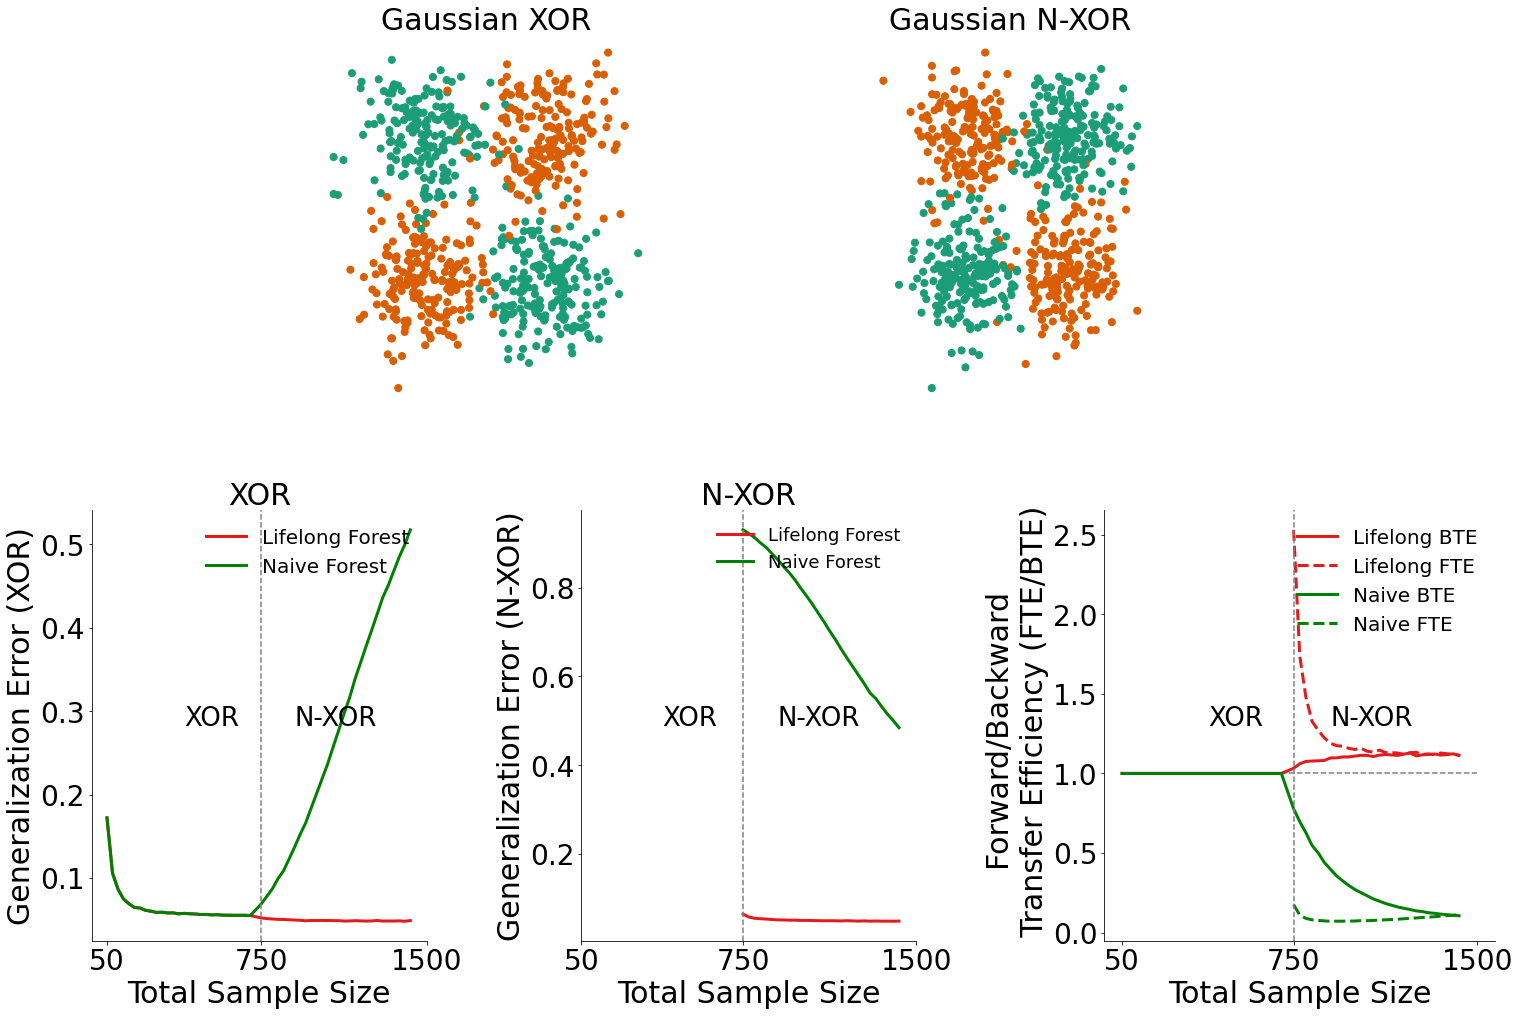

In [4]:
with open('plots/mean_xor_nxor.pickle','rb') as f:
    mean_error = pickle.load(f)

n_xor = (100*np.arange(0.5, 7.25, step=0.25)).astype(int)
n_nxor = (100*np.arange(0.5, 7.50, step=0.25)).astype(int)

n1s = n_xor
n2s = n_nxor

ns = np.concatenate((n1s, n2s + n1s[-1]))
ls=['-', '--']
algorithms = ['XOR Forest', 'N-XOR Forest', 'Lifelong Forest', 'Naive Forest']


TASK1='XOR'
TASK2='N-XOR'

fontsize=30
labelsize=28

colors = sns.color_palette("Set1", n_colors = 2)

fig = plt.figure(constrained_layout=True,figsize=(21,14))
gs = fig.add_gridspec(14, 21)
ax1 = fig.add_subplot(gs[7:,:6])
ax1.plot(ns, mean_error[1], label=algorithms[2], c=colors[0], ls=ls[np.sum(1 > 1).astype(int)], lw=3)
ax1.plot(ns, mean_error[4], label=algorithms[3], c='g', ls=ls[np.sum(1 > 1).astype(int)], lw=3)

ax1.set_ylabel('Generalization Error (%s)'%(TASK1), fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=20, frameon=False)
#ax1.set_ylim(0.09, 0.21)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
#ax1.set_yticks([0.5,0.15, 0.25])
ax1.set_xticks([50,750,1500])
ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")
ax1.set_title('XOR', fontsize=30)

right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)

ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)

#####################################
with open('plots/mean_xor_nxor.pickle','rb') as f:
    mean_error = pickle.load(f)

algorithms = ['XOR Forest', 'N-XOR Forest', 'Lifelong Forest', 'Naive Forest']

TASK1='XOR'
TASK2='N-XOR'

ax1 = fig.add_subplot(gs[7:,7:13])

ax1.plot(ns[len(n1s):], mean_error[3, len(n1s):], label=algorithms[2], c=colors[0], lw=3)
ax1.plot(ns[len(n1s):], mean_error[5, len(n1s):], label=algorithms[3], c='g', lw=3)

ax1.set_ylabel('Generalization Error (%s)'%(TASK2), fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=18, frameon=False)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
ax1.set_xticks([50,750,1500])
ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")


right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)

ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)

ax1.set_title('N-XOR', fontsize=30)

#####################################
with open('plots/mean_te_xor_nxor.pickle','rb') as f:
    mean_te = pickle.load(f)

algorithms = ['Lifelong BTE', 'Lifelong FTE', 'Naive BTE', 'Naive FTE']

TASK1='XOR'
TASK2='N-XOR'

ax1 = fig.add_subplot(gs[7:,14:])

ax1.plot(ns, mean_te[0], label=algorithms[0], c=colors[0], ls=ls[0], lw=3)
ax1.plot(ns[len(n1s):], mean_te[1, len(n1s):], label=algorithms[1], c=colors[0], ls=ls[1], lw=3)
ax1.plot(ns, mean_te[2], label=algorithms[2], c='g', ls=ls[0], lw=3)
ax1.plot(ns[len(n1s):], mean_te[3, len(n1s):], label=algorithms[3], c='g', ls=ls[1], lw=3)

ax1.set_ylabel('Forward/Backward \n Transfer Efficiency (FTE/BTE)', fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=20, frameon=False)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
#ax1.set_yticks([0,.5,1,1.5])
ax1.set_xticks([50,750,1500])
ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.hlines(1, 50,1500, colors='gray', linestyles='dashed',linewidth=1.5)

ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)

colors = sns.color_palette('Dark2', n_colors=2)

X, Y = generate_gaussian_parity(750, angle_params=0)
Z, W = generate_gaussian_parity(750, angle_params=np.pi/2)

ax = fig.add_subplot(gs[:6,4:10])
clr = [colors[i] for i in Y]
ax.scatter(X[:, 0], X[:, 1], c=clr, s=50)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Gaussian XOR', fontsize=30)

plt.tight_layout()
ax.axis('off')

colors = sns.color_palette('Dark2', n_colors=2)

ax = fig.add_subplot(gs[:6,11:16])
clr = [colors[i] for i in W]
ax.scatter(Z[:, 0], Z[:, 1], c=clr, s=50)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Gaussian N-XOR', fontsize=30)
ax.axis('off')

# Run experiment for XOR R-XOR tasks

In [ ]:
mc_rep = 1000
n_test = 1000
n_trees = 10
n_xor = (100*np.arange(0.5, 7.25, step=0.25)).astype(int)
n_rxor = (100*np.arange(0.5, 7.50, step=0.25)).astype(int)

mean_error = np.zeros((6, len(n_xor)+len(n_rxor)))
std_error = np.zeros((6, len(n_xor)+len(n_rxor)))

mean_te = np.zeros((4, len(n_xor)+len(n_rxor)))
std_te = np.zeros((4, len(n_xor)+len(n_rxor)))

for i,n1 in enumerate(n_xor):
    print('starting to compute %s xor\n'%n1)
    error = np.array(
        Parallel(n_jobs=-1,verbose=1)(
        delayed(experiment)(
            n1,0,task2_angle=np.pi/4,
            max_depth=ceil(log2(750))
        ) for _ in range(mc_rep)
      )
    )
    mean_error[:,i] = np.mean(error,axis=0)
    std_error[:,i] = np.std(error,ddof=1,axis=0)
    mean_te[0,i] = np.mean(error[:,0])/np.mean(error[:,1])
    mean_te[1,i] = np.mean(error[:,2])/np.mean(error[:,3])
    mean_te[2,i] = np.mean(error[:,0])/np.mean(error[:,4])
    mean_te[3,i] = np.mean(error[:,2])/np.mean(error[:,5])

    if n1==n_xor[-1]:
        for j,n2 in enumerate(n_rxor):
            print('starting to compute %s rxor\n'%n2)
            
            error = np.array(
                Parallel(n_jobs=-1,verbose=1)(
                delayed(experiment)(
                    n1,n2,task2_angle=np.pi/4,
                    max_depth=ceil(log2(750))
                ) for _ in range(mc_rep)
              )
            )
            mean_error[:,i+j+1] = np.mean(error,axis=0)
            std_error[:,i+j+1] = np.std(error,ddof=1,axis=0)
            mean_te[0,i+j+1] = np.mean(error[:,0])/np.mean(error[:,1])
            mean_te[1,i+j+1] = np.mean(error[:,2])/np.mean(error[:,3])
            mean_te[2,i+j+1] = np.mean(error[:,0])/np.mean(error[:,4])
            mean_te[3,i+j+1] = np.mean(error[:,2])/np.mean(error[:,5])

with open('./data/mean_xor_rxor.pickle','wb') as f:
    pickle.dump(mean_error,f)
    
with open('./data/std_xor_rxor.pickle','wb') as f:
    pickle.dump(std_error,f)
    
with open('./data/mean_te_xor_rxor.pickle','wb') as f:
    pickle.dump(mean_te,f)

# Plot XOR R-XOR results

(-1.4876070293805217,
 1.4810739177237267,
 -1.562534073924033,
 1.6533632050666698)

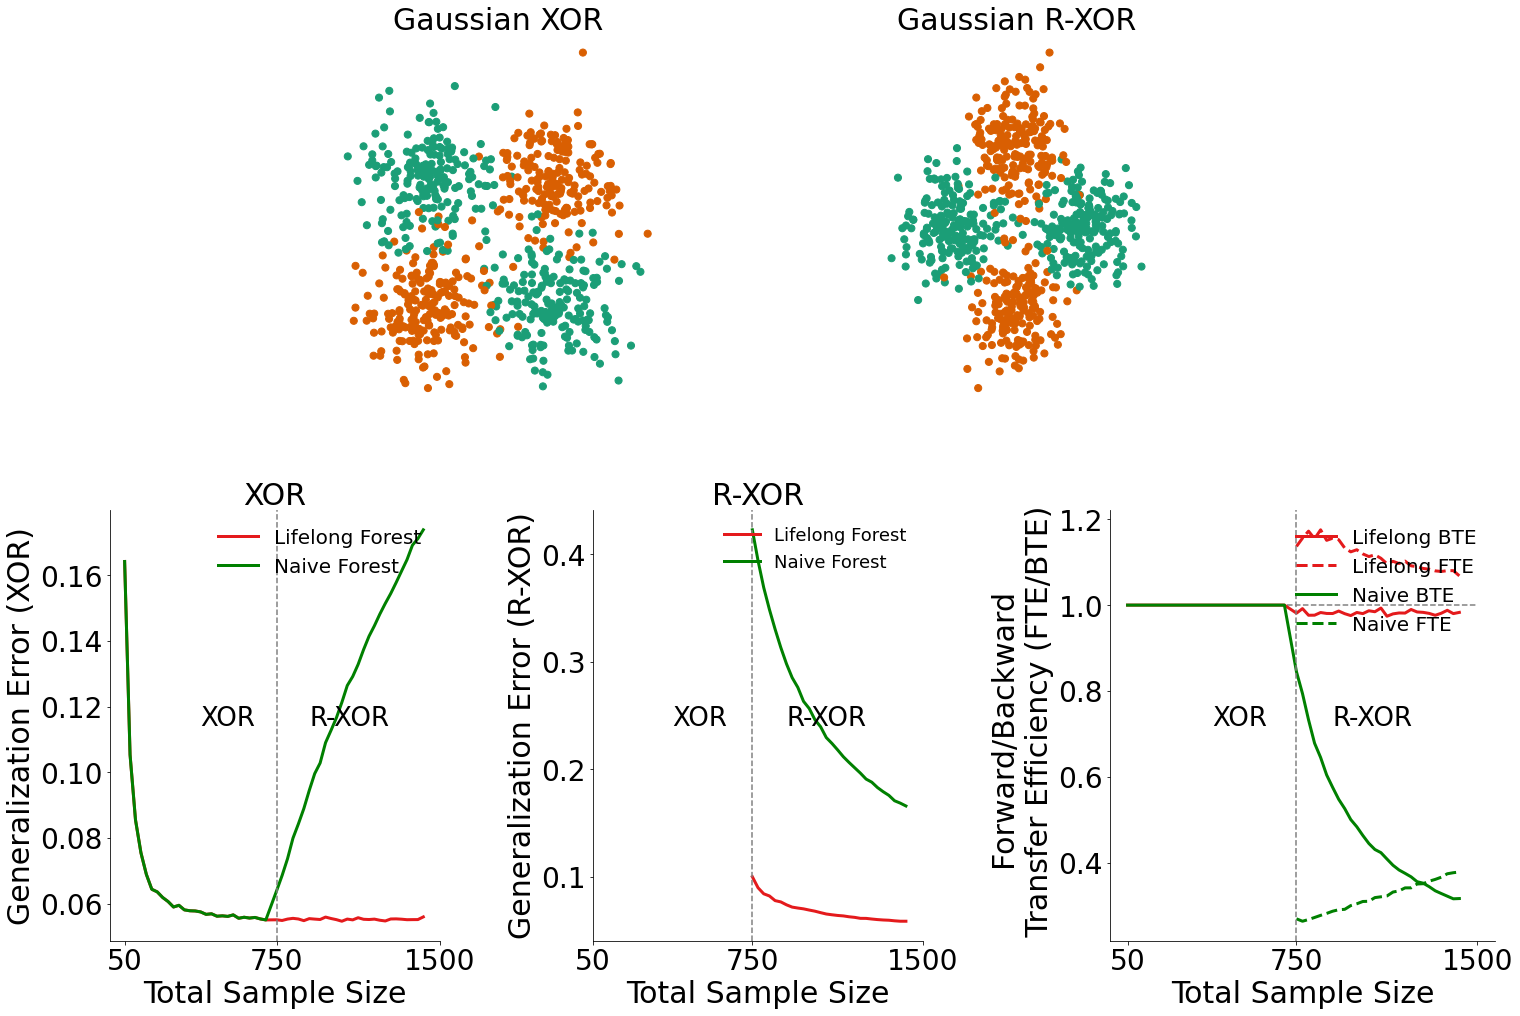

In [7]:
with open('plots/mean_xor_rxor.pickle','rb') as f:
    mean_error = pickle.load(f)

n_xor = (100*np.arange(0.5, 7.25, step=0.25)).astype(int)
n_nxor = (100*np.arange(0.5, 7.50, step=0.25)).astype(int)

n1s = n_xor
n2s = n_nxor

ns = np.concatenate((n1s, n2s + n1s[-1]))
ls=['-', '--']
algorithms = ['XOR Forest', 'R-XOR Forest', 'Lifelong Forest', 'Naive Forest']


TASK1='XOR'
TASK2='R-XOR'

fontsize=30
labelsize=28

colors = sns.color_palette("Set1", n_colors = 2)

fig = plt.figure(constrained_layout=True,figsize=(21,14))
gs = fig.add_gridspec(14, 21)
ax1 = fig.add_subplot(gs[7:,:6])
ax1.plot(ns, mean_error[1], label=algorithms[2], c=colors[0], ls=ls[np.sum(1 > 1).astype(int)], lw=3)
ax1.plot(ns, mean_error[4], label=algorithms[3], c='g', ls=ls[np.sum(1 > 1).astype(int)], lw=3)

ax1.set_ylabel('Generalization Error (%s)'%(TASK1), fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=20, frameon=False)
#ax1.set_ylim(0.09, 0.21)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
#ax1.set_yticks([0.1,0.15, 0.2])
ax1.set_xticks([50,750,1500])
ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")
ax1.set_title('XOR', fontsize=30)

right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)

ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)

#####################################
with open('plots/mean_xor_rxor.pickle','rb') as f:
    mean_error = pickle.load(f)

algorithms = ['XOR Forest', 'R-XOR Forest', 'Lifelong Forest', 'Naive Forest']

TASK1='XOR'
TASK2='R-XOR'

ax1 = fig.add_subplot(gs[7:,7:13])

ax1.plot(ns[len(n1s):], mean_error[3, len(n1s):], label=algorithms[2], c=colors[0], lw=3)
ax1.plot(ns[len(n1s):], mean_error[5, len(n1s):], label=algorithms[3], c='g', lw=3)

ax1.set_ylabel('Generalization Error (%s)'%(TASK2), fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=18, frameon=False)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
ax1.set_xticks([50,750,1500])
ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")


right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)

ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)

ax1.set_title('R-XOR', fontsize=30)

#####################################
with open('plots/mean_te_xor_rxor.pickle','rb') as f:
    mean_te = pickle.load(f)

algorithms = ['Lifelong BTE', 'Lifelong FTE', 'Naive BTE', 'Naive FTE']

TASK1='XOR'
TASK2='R-XOR'

ax1 = fig.add_subplot(gs[7:,14:])

ax1.plot(ns, mean_te[0], label=algorithms[0], c=colors[0], ls=ls[0], lw=3)
ax1.plot(ns[len(n1s):], mean_te[1, len(n1s):], label=algorithms[1], c=colors[0], ls=ls[1], lw=3)
ax1.plot(ns, mean_te[2], label=algorithms[2], c='g', ls=ls[0], lw=3)
ax1.plot(ns[len(n1s):], mean_te[3, len(n1s):], label=algorithms[3], c='g', ls=ls[1], lw=3)

ax1.set_ylabel('Forward/Backward \n Transfer Efficiency (FTE/BTE)', fontsize=fontsize)
ax1.legend(loc='upper right', fontsize=20, frameon=False)
ax1.set_xlabel('Total Sample Size', fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
#ax1.set_yticks([0,.5,1,1.5])
ax1.set_xticks([50,750,1500])
ax1.axvline(x=750, c='gray', linewidth=1.5, linestyle="dashed")
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.hlines(1, 50,1500, colors='gray', linestyles='dashed',linewidth=1.5)

ax1.text(400, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=26)
ax1.text(900, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=26)

colors = sns.color_palette('Dark2', n_colors=2)

X, Y = generate_gaussian_parity(750, angle_params=0)
Z, W = generate_gaussian_parity(750, angle_params=np.pi/4)

ax = fig.add_subplot(gs[:6,4:10])
clr = [colors[i] for i in Y]
ax.scatter(X[:, 0], X[:, 1], c=clr, s=50)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Gaussian XOR', fontsize=30)

plt.tight_layout()
ax.axis('off')

colors = sns.color_palette('Dark2', n_colors=2)

ax = fig.add_subplot(gs[:6,11:16])
clr = [colors[i] for i in W]
ax.scatter(Z[:, 0], Z[:, 1], c=clr, s=50)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Gaussian R-XOR', fontsize=30)
ax.axis('off')

# Experiment for Backward Transfer Efficiency (BTE) vs. angle of rotation for the second task

In [ ]:
###main hyperparameters###
angle_sweep = range(0,90,1)
task1_sample = 100
task2_sample = 100
mc_rep = 10000

mean_te = np.zeros(len(angle_sweep), dtype=float)
for ii,angle in enumerate(angle_sweep):
    error = np.array(
        Parallel(n_jobs=-1,verbose=1)(
        delayed(experiment)(
            task1_sample,task2_sample,
            task2_angle=angle*np.pi/180, 
            max_depth=ceil(log2(task1_sample))
        ) for _ in range(mc_rep)
      )
    )

    mean_te[ii] = np.mean(error[:,0])/np.mean(error[:,1])

with open('./data/mean_angle_te.pickle','wb') as f:
    pickle.dump(mean_te,f)


# Plot the result

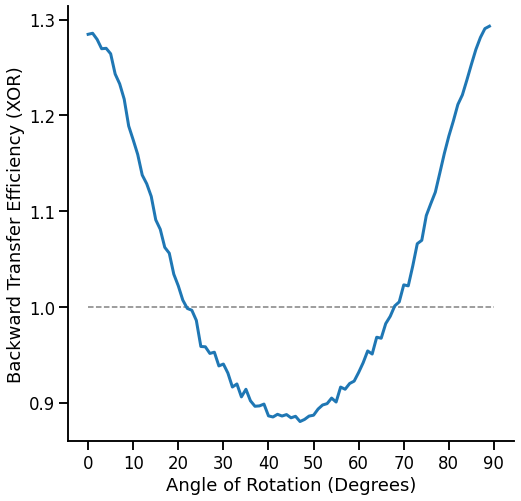

In [57]:
with open('./data/mean_angle_te.pickle','rb') as f:
    te = pickle.load(f)
angle_sweep = range(0,90,1)

sns.set_context("talk")
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(angle_sweep,te,linewidth = 3)
ax.set_xticks(range(0,91,10))
ax.set_xlabel('Angle of Rotation (Degrees)')
ax.set_ylabel('Backward Transfer Efficiency (XOR)')
ax.hlines(1, 0,90, colors='gray', linestyles='dashed',linewidth=1.5)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)


# Experiment for Backward Transfer Efficiency (BTE) vs. number of training samples for the second task

In [6]:
###main hyperparameters###
task2_sample_sweep = (2**np.arange(np.log2(60), np.log2(5010)+1, .25)).astype('int')
task1_sample = 500
task2_angle = 25*np.pi/180
mc_rep = 1000

mean_te = np.zeros(len(task2_sample_sweep), dtype=float)
for ii,sample_no in enumerate(task2_sample_sweep):
    error = np.array(
        Parallel(n_jobs=-1,verbose=1)(
        delayed(experiment)(
            task1_sample,sample_no,
            task2_angle=task2_angle, 
            max_depth=None
        ) for _ in range(mc_rep)
      )
    )

    mean_te[ii] = np.mean(error[:,0])/np.mean(error[:,1])

with open('./data/mean_sample_te.pickle','wb') as f:
    pickle.dump(mean_te,f)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    8.3s f

# Plot the result

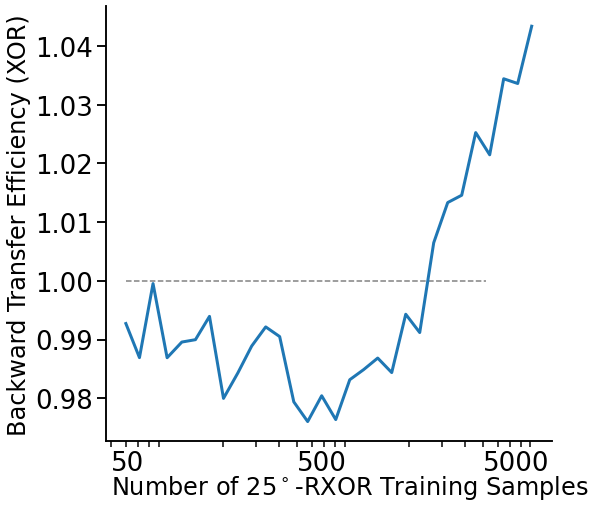

In [14]:
with open('./data/mean_sample_te.pickle','rb') as f:
    te = pickle.load(f)
task2_sample_sweep = (2**np.arange(np.log2(60), np.log2(5010)+1, .25)).astype('int')

sns.set_context("talk")
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(task2_sample_sweep,te,linewidth = 3)
ax.hlines(1, 60,5200, colors='gray', linestyles='dashed',linewidth=1.5)
ax.set_xscale('log')
ax.set_xticks([])
#ax.set_yticks([0.87,0.9,0.93])
ax.tick_params(labelsize=26)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.text(50, np.mean(ax.get_ylim())-.042, "50", fontsize=26)
ax.text(500, np.mean(ax.get_ylim())-.042, "500", fontsize=26)
ax.text(5000, np.mean(ax.get_ylim())-.042, "5000", fontsize=26)

ax.text(50, np.mean(ax.get_ylim())-.046, "Number of $25^\circ$-RXOR Training Samples", fontsize=24)
ax.set_ylabel('Backward Transfer Efficiency (XOR)',fontsize=24)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)